# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize image
                                    transforms.ToTensor()])

    # get directory
    image_path = './' + data_dir
    #train_path = os.path.join(image_path, image_type)
    #test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    image_dataset = datasets.ImageFolder(image_path, transform)
    #test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    image_loader = DataLoader(dataset=image_dataset, batch_size=batch_size, shuffle=True)
    #test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return image_loader  


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 20  # From past CycleGAN example I used 16, but had to push to 20 for the cell below this one
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

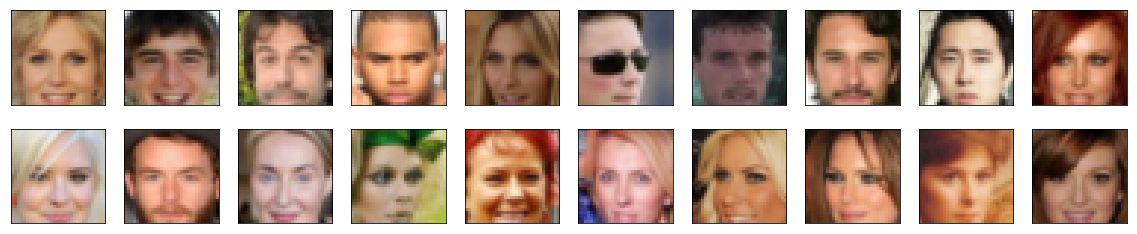

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transposing image of x, y, z to z, x, y (colors=3, width=32, height=32)
                                                # where x=width, y=height, and z=number of color layers (RGB)
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(1.00000e-02 *
       8.6275)
Max:  tensor(0.8863)


In [8]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min    
    
    return x


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8275)
Max:  tensor(0.7725)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=64):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # Convolutional layers, increasing in depth
        
        # first layer has *no* batchnorm
        # 32 x 32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64. No BatchNorm
        # 16 x 16 output
        
        # 16 x 16 input
        self.conv2 = conv(conv_dim, (conv_dim * 2), 4) 
        # 8 x 8 output
        
        # 8 x 8 input
        self.conv3 = conv((conv_dim * 2), (conv_dim * 4), 4) 
        # 4 x 4 output
        
        # 4 x 4 input
        self.conv4 = conv((conv_dim * 4), (conv_dim * 8), 4)
        # 2 x 2 output
        
        # Classification layer
        self.fc = nn.Linear((conv_dim * 8 * 2 * 2), 1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # leaky_relu applied to all conv layers but last

        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
                
        # flatten
        out = out.view(-1, self.conv_dim * 8 * 2 * 2)
        
        # last, classification layer
        final_out = self.fc(out)
        
        return final_out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [13]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim * 8 * 2 * 2)

        # transpose conv layers
        self.t_conv1 = deconv((conv_dim * 8), (conv_dim * 4), 4)
        self.t_conv2 = deconv((conv_dim * 4), (conv_dim * 2), 4)
        self.t_conv3 = deconv((conv_dim * 2), (conv_dim), 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim * 8, 2, 2) 
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        
        # last layer + tanh activation
        out = self.t_conv4(out)
        out = F.tanh(out) 
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [15]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.2)

        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_() # set bias terms to zero

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [17]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100  # to start with

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fal

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [27]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    '''
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    '''
    labels = torch.ones(batch_size) * 0.9
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [28]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [29]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
        
            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
        
            # 2. Train with fake images
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            # add up loss and perform backprop            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
        
            # 1. Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)            
            
            g_loss = real_loss(D_fake) # use real loss to flip labels
            
            # perform backprop
            g_loss.backward()
            g_optimizer.step()            
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [30]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.5100 | g_loss: 1.3077
Epoch [    1/   50] | d_loss: 0.6134 | g_loss: 5.6967
Epoch [    1/   50] | d_loss: 0.4469 | g_loss: 5.3855
Epoch [    1/   50] | d_loss: 0.4266 | g_loss: 5.5780
Epoch [    1/   50] | d_loss: 0.4462 | g_loss: 6.1316
Epoch [    1/   50] | d_loss: 0.3973 | g_loss: 5.9934
Epoch [    1/   50] | d_loss: 0.3998 | g_loss: 5.6011
Epoch [    1/   50] | d_loss: 0.4487 | g_loss: 5.3678
Epoch [    1/   50] | d_loss: 0.4074 | g_loss: 6.2463
Epoch [    1/   50] | d_loss: 0.4168 | g_loss: 5.3067
Epoch [    1/   50] | d_loss: 0.3929 | g_loss: 5.4086
Epoch [    1/   50] | d_loss: 0.3926 | g_loss: 5.3306
Epoch [    1/   50] | d_loss: 0.4123 | g_loss: 5.3338
Epoch [    1/   50] | d_loss: 0.3776 | g_loss: 5.6183
Epoch [    1/   50] | d_loss: 0.3759 | g_loss: 5.4695
Epoch [    1/   50] | d_loss: 0.4189 | g_loss: 6.0049
Epoch [    1/   50] | d_loss: 0.3798 | g_loss: 6.4087
Epoch [    1/   50] | d_loss: 0.3471 | g_loss: 6.1553
Epoch [    1/   50] | d_loss

Epoch [    2/   50] | d_loss: 0.6896 | g_loss: 2.6585
Epoch [    2/   50] | d_loss: 0.8217 | g_loss: 0.9949
Epoch [    2/   50] | d_loss: 1.7254 | g_loss: 1.8546
Epoch [    2/   50] | d_loss: 1.1400 | g_loss: 2.3403
Epoch [    2/   50] | d_loss: 0.8182 | g_loss: 2.9168
Epoch [    2/   50] | d_loss: 0.6773 | g_loss: 1.8623
Epoch [    2/   50] | d_loss: 0.8604 | g_loss: 2.0606
Epoch [    2/   50] | d_loss: 0.6145 | g_loss: 2.0059
Epoch [    2/   50] | d_loss: 0.8961 | g_loss: 2.2963
Epoch [    2/   50] | d_loss: 0.7260 | g_loss: 1.5054
Epoch [    2/   50] | d_loss: 0.5791 | g_loss: 1.7900
Epoch [    2/   50] | d_loss: 0.5922 | g_loss: 2.4134
Epoch [    2/   50] | d_loss: 0.5196 | g_loss: 2.3590
Epoch [    2/   50] | d_loss: 0.6901 | g_loss: 2.5273
Epoch [    2/   50] | d_loss: 0.7945 | g_loss: 1.6037
Epoch [    2/   50] | d_loss: 0.7224 | g_loss: 2.4761
Epoch [    2/   50] | d_loss: 0.8429 | g_loss: 1.1721
Epoch [    2/   50] | d_loss: 0.5310 | g_loss: 2.8006
Epoch [    2/   50] | d_loss

Epoch [    4/   50] | d_loss: 0.4774 | g_loss: 2.6368
Epoch [    4/   50] | d_loss: 0.6491 | g_loss: 3.2653
Epoch [    4/   50] | d_loss: 0.7824 | g_loss: 1.9324
Epoch [    4/   50] | d_loss: 0.4528 | g_loss: 2.5190
Epoch [    4/   50] | d_loss: 1.2251 | g_loss: 1.8079
Epoch [    4/   50] | d_loss: 0.4539 | g_loss: 2.5061
Epoch [    4/   50] | d_loss: 0.5260 | g_loss: 2.8843
Epoch [    4/   50] | d_loss: 0.4828 | g_loss: 2.1755
Epoch [    4/   50] | d_loss: 0.7398 | g_loss: 1.8413
Epoch [    4/   50] | d_loss: 0.5718 | g_loss: 2.2260
Epoch [    4/   50] | d_loss: 0.6184 | g_loss: 2.4620
Epoch [    4/   50] | d_loss: 0.5240 | g_loss: 2.7043
Epoch [    4/   50] | d_loss: 1.3670 | g_loss: 1.5627
Epoch [    4/   50] | d_loss: 0.4656 | g_loss: 3.1832
Epoch [    4/   50] | d_loss: 0.6238 | g_loss: 1.9364
Epoch [    4/   50] | d_loss: 0.5569 | g_loss: 1.9147
Epoch [    4/   50] | d_loss: 0.8752 | g_loss: 1.0848
Epoch [    4/   50] | d_loss: 0.9840 | g_loss: 2.4152
Epoch [    4/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.5255 | g_loss: 4.0336
Epoch [    6/   50] | d_loss: 0.5017 | g_loss: 3.4787
Epoch [    6/   50] | d_loss: 0.5968 | g_loss: 2.7616
Epoch [    6/   50] | d_loss: 0.3932 | g_loss: 3.5279
Epoch [    6/   50] | d_loss: 0.4242 | g_loss: 3.8689
Epoch [    6/   50] | d_loss: 0.4900 | g_loss: 3.3292
Epoch [    6/   50] | d_loss: 0.7794 | g_loss: 2.1947
Epoch [    6/   50] | d_loss: 0.4682 | g_loss: 2.4761
Epoch [    6/   50] | d_loss: 0.8027 | g_loss: 2.9524
Epoch [    6/   50] | d_loss: 0.4104 | g_loss: 4.1154
Epoch [    6/   50] | d_loss: 0.4221 | g_loss: 3.1522
Epoch [    6/   50] | d_loss: 0.7290 | g_loss: 2.4104
Epoch [    6/   50] | d_loss: 0.4759 | g_loss: 3.2877
Epoch [    6/   50] | d_loss: 0.3967 | g_loss: 4.8379
Epoch [    6/   50] | d_loss: 0.4289 | g_loss: 4.1854
Epoch [    6/   50] | d_loss: 0.4197 | g_loss: 4.7406
Epoch [    6/   50] | d_loss: 0.7517 | g_loss: 3.8304
Epoch [    6/   50] | d_loss: 0.7226 | g_loss: 2.6495
Epoch [    6/   50] | d_loss

Epoch [    7/   50] | d_loss: 0.7279 | g_loss: 1.6690
Epoch [    7/   50] | d_loss: 0.4796 | g_loss: 3.4112
Epoch [    7/   50] | d_loss: 0.3760 | g_loss: 4.3268
Epoch [    7/   50] | d_loss: 0.5465 | g_loss: 4.3995
Epoch [    7/   50] | d_loss: 0.4393 | g_loss: 3.6554
Epoch [    7/   50] | d_loss: 0.5642 | g_loss: 3.2766
Epoch [    7/   50] | d_loss: 0.4070 | g_loss: 3.4198
Epoch [    7/   50] | d_loss: 0.4096 | g_loss: 4.2886
Epoch [    7/   50] | d_loss: 0.4780 | g_loss: 3.9650
Epoch [    7/   50] | d_loss: 0.4099 | g_loss: 3.6524
Epoch [    7/   50] | d_loss: 0.6426 | g_loss: 2.4579
Epoch [    7/   50] | d_loss: 0.4151 | g_loss: 3.2214
Epoch [    7/   50] | d_loss: 0.3594 | g_loss: 4.1723
Epoch [    7/   50] | d_loss: 0.3899 | g_loss: 4.2787
Epoch [    7/   50] | d_loss: 0.4937 | g_loss: 3.5343
Epoch [    7/   50] | d_loss: 0.5502 | g_loss: 4.4474
Epoch [    7/   50] | d_loss: 0.5237 | g_loss: 1.9947
Epoch [    7/   50] | d_loss: 0.4114 | g_loss: 3.5490
Epoch [    7/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.4596 | g_loss: 5.2071
Epoch [    9/   50] | d_loss: 0.6453 | g_loss: 3.0852
Epoch [    9/   50] | d_loss: 0.4593 | g_loss: 3.0665
Epoch [    9/   50] | d_loss: 0.5611 | g_loss: 3.1495
Epoch [    9/   50] | d_loss: 0.4126 | g_loss: 3.3137
Epoch [    9/   50] | d_loss: 0.6588 | g_loss: 2.8419
Epoch [    9/   50] | d_loss: 0.4454 | g_loss: 3.0543
Epoch [    9/   50] | d_loss: 0.4823 | g_loss: 2.6359
Epoch [    9/   50] | d_loss: 0.4377 | g_loss: 3.8507
Epoch [    9/   50] | d_loss: 0.5702 | g_loss: 2.2365
Epoch [    9/   50] | d_loss: 0.4377 | g_loss: 4.2477
Epoch [    9/   50] | d_loss: 0.5641 | g_loss: 3.7485
Epoch [    9/   50] | d_loss: 0.4043 | g_loss: 2.6225
Epoch [    9/   50] | d_loss: 0.5110 | g_loss: 3.1660
Epoch [    9/   50] | d_loss: 0.4023 | g_loss: 4.1513
Epoch [    9/   50] | d_loss: 0.5636 | g_loss: 2.3061
Epoch [    9/   50] | d_loss: 1.1352 | g_loss: 1.6927
Epoch [    9/   50] | d_loss: 0.3875 | g_loss: 3.2238
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.3814 | g_loss: 3.4390
Epoch [   11/   50] | d_loss: 0.6493 | g_loss: 3.3652
Epoch [   11/   50] | d_loss: 0.5104 | g_loss: 2.7022
Epoch [   11/   50] | d_loss: 0.5307 | g_loss: 2.5325
Epoch [   11/   50] | d_loss: 0.3537 | g_loss: 4.1508
Epoch [   11/   50] | d_loss: 0.3599 | g_loss: 2.0427
Epoch [   11/   50] | d_loss: 0.3675 | g_loss: 4.0811
Epoch [   11/   50] | d_loss: 0.3653 | g_loss: 5.1513
Epoch [   11/   50] | d_loss: 0.5142 | g_loss: 3.6011
Epoch [   11/   50] | d_loss: 0.5762 | g_loss: 4.2213
Epoch [   11/   50] | d_loss: 0.4970 | g_loss: 3.2500
Epoch [   11/   50] | d_loss: 0.4242 | g_loss: 2.9960
Epoch [   11/   50] | d_loss: 0.8848 | g_loss: 3.1632
Epoch [   11/   50] | d_loss: 0.4108 | g_loss: 3.0533
Epoch [   11/   50] | d_loss: 0.4070 | g_loss: 4.2685
Epoch [   11/   50] | d_loss: 0.4978 | g_loss: 3.1205
Epoch [   11/   50] | d_loss: 0.3698 | g_loss: 3.5789
Epoch [   11/   50] | d_loss: 0.6028 | g_loss: 2.7345
Epoch [   11/   50] | d_loss

Epoch [   12/   50] | d_loss: 0.3732 | g_loss: 2.7849
Epoch [   12/   50] | d_loss: 0.3716 | g_loss: 3.8674
Epoch [   12/   50] | d_loss: 0.4831 | g_loss: 3.3005
Epoch [   12/   50] | d_loss: 0.6022 | g_loss: 3.0783
Epoch [   12/   50] | d_loss: 0.6047 | g_loss: 3.1526
Epoch [   12/   50] | d_loss: 0.5132 | g_loss: 3.2141
Epoch [   12/   50] | d_loss: 0.3878 | g_loss: 4.1679
Epoch [   12/   50] | d_loss: 0.5909 | g_loss: 1.9857
Epoch [   12/   50] | d_loss: 0.9908 | g_loss: 3.3568
Epoch [   12/   50] | d_loss: 0.6772 | g_loss: 2.8803
Epoch [   12/   50] | d_loss: 0.4425 | g_loss: 4.9602
Epoch [   12/   50] | d_loss: 0.4534 | g_loss: 2.8418
Epoch [   12/   50] | d_loss: 0.4157 | g_loss: 4.8999
Epoch [   12/   50] | d_loss: 0.5324 | g_loss: 1.7390
Epoch [   12/   50] | d_loss: 0.4259 | g_loss: 3.3469
Epoch [   12/   50] | d_loss: 0.4049 | g_loss: 1.8581
Epoch [   13/   50] | d_loss: 0.3507 | g_loss: 4.7205
Epoch [   13/   50] | d_loss: 0.4280 | g_loss: 4.3066
Epoch [   13/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.3690 | g_loss: 4.7170
Epoch [   14/   50] | d_loss: 0.3995 | g_loss: 3.0635
Epoch [   14/   50] | d_loss: 0.3908 | g_loss: 5.2121
Epoch [   14/   50] | d_loss: 0.3830 | g_loss: 4.7051
Epoch [   14/   50] | d_loss: 0.4415 | g_loss: 3.7427
Epoch [   14/   50] | d_loss: 0.3658 | g_loss: 5.1032
Epoch [   14/   50] | d_loss: 0.3664 | g_loss: 6.1362
Epoch [   14/   50] | d_loss: 0.3464 | g_loss: 5.5905
Epoch [   14/   50] | d_loss: 0.3487 | g_loss: 6.5979
Epoch [   14/   50] | d_loss: 0.3787 | g_loss: 4.9838
Epoch [   14/   50] | d_loss: 0.3552 | g_loss: 5.6196
Epoch [   14/   50] | d_loss: 0.3942 | g_loss: 5.6661
Epoch [   14/   50] | d_loss: 0.4083 | g_loss: 5.0729
Epoch [   14/   50] | d_loss: 0.3559 | g_loss: 6.8706
Epoch [   14/   50] | d_loss: 0.3449 | g_loss: 4.8661
Epoch [   14/   50] | d_loss: 0.3923 | g_loss: 5.2729
Epoch [   14/   50] | d_loss: 0.3722 | g_loss: 4.4550
Epoch [   14/   50] | d_loss: 0.3436 | g_loss: 5.4489
Epoch [   14/   50] | d_loss

Epoch [   16/   50] | d_loss: 1.2682 | g_loss: 2.1913
Epoch [   16/   50] | d_loss: 0.3623 | g_loss: 3.9880
Epoch [   16/   50] | d_loss: 0.4117 | g_loss: 2.7398
Epoch [   16/   50] | d_loss: 0.3841 | g_loss: 4.9047
Epoch [   16/   50] | d_loss: 0.3596 | g_loss: 4.7357
Epoch [   16/   50] | d_loss: 0.3548 | g_loss: 3.6728
Epoch [   16/   50] | d_loss: 0.3984 | g_loss: 4.6041
Epoch [   16/   50] | d_loss: 0.6008 | g_loss: 2.6817
Epoch [   16/   50] | d_loss: 0.4017 | g_loss: 3.6418
Epoch [   16/   50] | d_loss: 0.3926 | g_loss: 3.9331
Epoch [   16/   50] | d_loss: 0.3729 | g_loss: 4.6422
Epoch [   16/   50] | d_loss: 0.3644 | g_loss: 4.9043
Epoch [   16/   50] | d_loss: 0.3501 | g_loss: 4.4897
Epoch [   16/   50] | d_loss: 0.4202 | g_loss: 4.1525
Epoch [   16/   50] | d_loss: 0.3720 | g_loss: 4.3035
Epoch [   16/   50] | d_loss: 0.4841 | g_loss: 3.7721
Epoch [   16/   50] | d_loss: 0.3603 | g_loss: 4.4099
Epoch [   16/   50] | d_loss: 0.3722 | g_loss: 5.1644
Epoch [   16/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.4702 | g_loss: 4.0633
Epoch [   17/   50] | d_loss: 0.3976 | g_loss: 3.4995
Epoch [   17/   50] | d_loss: 0.3611 | g_loss: 5.1020
Epoch [   17/   50] | d_loss: 0.4433 | g_loss: 4.2643
Epoch [   17/   50] | d_loss: 0.4234 | g_loss: 3.9293
Epoch [   17/   50] | d_loss: 0.3616 | g_loss: 4.8650
Epoch [   17/   50] | d_loss: 0.3879 | g_loss: 3.7874
Epoch [   17/   50] | d_loss: 0.4102 | g_loss: 4.5258
Epoch [   17/   50] | d_loss: 0.4541 | g_loss: 3.7804
Epoch [   17/   50] | d_loss: 0.3631 | g_loss: 4.9732
Epoch [   18/   50] | d_loss: 0.4939 | g_loss: 3.7704
Epoch [   18/   50] | d_loss: 0.3779 | g_loss: 4.2844
Epoch [   18/   50] | d_loss: 0.3724 | g_loss: 3.8224
Epoch [   18/   50] | d_loss: 0.3541 | g_loss: 4.3332
Epoch [   18/   50] | d_loss: 0.3532 | g_loss: 5.1121
Epoch [   18/   50] | d_loss: 0.3379 | g_loss: 5.7690
Epoch [   18/   50] | d_loss: 0.3640 | g_loss: 4.1282
Epoch [   18/   50] | d_loss: 0.3594 | g_loss: 4.1835
Epoch [   18/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.3508 | g_loss: 4.6702
Epoch [   19/   50] | d_loss: 0.3581 | g_loss: 3.8987
Epoch [   19/   50] | d_loss: 0.3887 | g_loss: 4.6237
Epoch [   19/   50] | d_loss: 0.4037 | g_loss: 3.8315
Epoch [   19/   50] | d_loss: 0.4075 | g_loss: 2.8035
Epoch [   19/   50] | d_loss: 0.3966 | g_loss: 3.9373
Epoch [   19/   50] | d_loss: 0.3780 | g_loss: 3.7488
Epoch [   19/   50] | d_loss: 0.3867 | g_loss: 5.2471
Epoch [   19/   50] | d_loss: 0.4427 | g_loss: 4.1831
Epoch [   19/   50] | d_loss: 0.4894 | g_loss: 2.9700
Epoch [   19/   50] | d_loss: 0.3799 | g_loss: 3.6185
Epoch [   19/   50] | d_loss: 0.4026 | g_loss: 5.1041
Epoch [   19/   50] | d_loss: 0.4282 | g_loss: 5.0188
Epoch [   19/   50] | d_loss: 0.3588 | g_loss: 3.4393
Epoch [   19/   50] | d_loss: 0.3950 | g_loss: 4.5896
Epoch [   19/   50] | d_loss: 0.4367 | g_loss: 2.5561
Epoch [   19/   50] | d_loss: 0.4097 | g_loss: 4.5476
Epoch [   19/   50] | d_loss: 0.3721 | g_loss: 4.6934
Epoch [   19/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.3554 | g_loss: 4.7154
Epoch [   21/   50] | d_loss: 0.3924 | g_loss: 4.0799
Epoch [   21/   50] | d_loss: 0.3994 | g_loss: 3.7441
Epoch [   21/   50] | d_loss: 0.3869 | g_loss: 5.8255
Epoch [   21/   50] | d_loss: 0.4355 | g_loss: 4.1416
Epoch [   21/   50] | d_loss: 0.4451 | g_loss: 3.3510
Epoch [   21/   50] | d_loss: 0.5748 | g_loss: 2.6996
Epoch [   21/   50] | d_loss: 0.4779 | g_loss: 3.7395
Epoch [   21/   50] | d_loss: 0.4133 | g_loss: 4.1644
Epoch [   21/   50] | d_loss: 0.4190 | g_loss: 4.7686
Epoch [   21/   50] | d_loss: 0.3573 | g_loss: 3.3115
Epoch [   21/   50] | d_loss: 0.4567 | g_loss: 3.2738
Epoch [   21/   50] | d_loss: 0.4280 | g_loss: 5.1999
Epoch [   21/   50] | d_loss: 0.3539 | g_loss: 5.2973
Epoch [   21/   50] | d_loss: 0.4033 | g_loss: 4.7327
Epoch [   21/   50] | d_loss: 0.4771 | g_loss: 5.5576
Epoch [   21/   50] | d_loss: 0.4806 | g_loss: 3.2676
Epoch [   21/   50] | d_loss: 0.4474 | g_loss: 3.4192
Epoch [   21/   50] | d_loss

Epoch [   23/   50] | d_loss: 0.3659 | g_loss: 4.2778
Epoch [   23/   50] | d_loss: 0.3723 | g_loss: 5.0401
Epoch [   23/   50] | d_loss: 0.3817 | g_loss: 5.3377
Epoch [   23/   50] | d_loss: 0.3787 | g_loss: 5.4171
Epoch [   23/   50] | d_loss: 0.4314 | g_loss: 3.8419
Epoch [   23/   50] | d_loss: 0.3974 | g_loss: 3.1904
Epoch [   23/   50] | d_loss: 0.3534 | g_loss: 4.6417
Epoch [   23/   50] | d_loss: 0.3933 | g_loss: 3.2145
Epoch [   23/   50] | d_loss: 0.4130 | g_loss: 4.8955
Epoch [   23/   50] | d_loss: 0.3914 | g_loss: 3.1323
Epoch [   23/   50] | d_loss: 0.4443 | g_loss: 3.2627
Epoch [   23/   50] | d_loss: 0.6862 | g_loss: 3.4973
Epoch [   23/   50] | d_loss: 0.3969 | g_loss: 3.1887
Epoch [   23/   50] | d_loss: 0.3483 | g_loss: 5.9628
Epoch [   23/   50] | d_loss: 0.4572 | g_loss: 3.6137
Epoch [   23/   50] | d_loss: 0.3689 | g_loss: 4.4759
Epoch [   23/   50] | d_loss: 0.3873 | g_loss: 4.3972
Epoch [   23/   50] | d_loss: 0.3653 | g_loss: 4.2040
Epoch [   23/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.3765 | g_loss: 2.8695
Epoch [   24/   50] | d_loss: 0.5219 | g_loss: 2.6011
Epoch [   24/   50] | d_loss: 0.4068 | g_loss: 3.7473
Epoch [   24/   50] | d_loss: 0.4234 | g_loss: 4.2532
Epoch [   24/   50] | d_loss: 0.6276 | g_loss: 3.6091
Epoch [   24/   50] | d_loss: 0.3905 | g_loss: 3.2654
Epoch [   24/   50] | d_loss: 0.5252 | g_loss: 3.0689
Epoch [   24/   50] | d_loss: 0.4293 | g_loss: 3.5845
Epoch [   24/   50] | d_loss: 0.4934 | g_loss: 2.3202
Epoch [   24/   50] | d_loss: 0.3576 | g_loss: 4.3435
Epoch [   24/   50] | d_loss: 0.4354 | g_loss: 4.9520
Epoch [   24/   50] | d_loss: 0.5465 | g_loss: 3.6633
Epoch [   24/   50] | d_loss: 0.4288 | g_loss: 4.4294
Epoch [   24/   50] | d_loss: 0.4741 | g_loss: 2.9355
Epoch [   24/   50] | d_loss: 0.4030 | g_loss: 2.2340
Epoch [   24/   50] | d_loss: 0.4205 | g_loss: 3.1301
Epoch [   24/   50] | d_loss: 0.3889 | g_loss: 2.9378
Epoch [   24/   50] | d_loss: 0.4675 | g_loss: 2.9619
Epoch [   24/   50] | d_loss

Epoch [   26/   50] | d_loss: 0.4179 | g_loss: 2.8710
Epoch [   26/   50] | d_loss: 0.4384 | g_loss: 3.2659
Epoch [   26/   50] | d_loss: 0.3664 | g_loss: 3.2012
Epoch [   26/   50] | d_loss: 0.5592 | g_loss: 2.7711
Epoch [   26/   50] | d_loss: 0.3938 | g_loss: 3.1834
Epoch [   26/   50] | d_loss: 0.4159 | g_loss: 3.9129
Epoch [   26/   50] | d_loss: 0.3949 | g_loss: 4.4974
Epoch [   26/   50] | d_loss: 0.3680 | g_loss: 3.4257
Epoch [   26/   50] | d_loss: 0.4459 | g_loss: 2.5941
Epoch [   26/   50] | d_loss: 0.3901 | g_loss: 3.3390
Epoch [   26/   50] | d_loss: 0.6879 | g_loss: 3.4356
Epoch [   26/   50] | d_loss: 0.4297 | g_loss: 4.1052
Epoch [   26/   50] | d_loss: 0.6032 | g_loss: 3.1371
Epoch [   26/   50] | d_loss: 0.4391 | g_loss: 3.0881
Epoch [   26/   50] | d_loss: 0.7583 | g_loss: 2.1554
Epoch [   26/   50] | d_loss: 0.4107 | g_loss: 3.1689
Epoch [   26/   50] | d_loss: 0.4346 | g_loss: 4.9067
Epoch [   26/   50] | d_loss: 0.5469 | g_loss: 1.8632
Epoch [   26/   50] | d_loss

Epoch [   28/   50] | d_loss: 0.4179 | g_loss: 2.4173
Epoch [   28/   50] | d_loss: 0.6087 | g_loss: 2.2626
Epoch [   28/   50] | d_loss: 0.3855 | g_loss: 3.6090
Epoch [   28/   50] | d_loss: 0.5110 | g_loss: 3.2352
Epoch [   28/   50] | d_loss: 0.5234 | g_loss: 3.4671
Epoch [   28/   50] | d_loss: 0.4124 | g_loss: 3.0107
Epoch [   28/   50] | d_loss: 0.5880 | g_loss: 2.5111
Epoch [   28/   50] | d_loss: 0.3967 | g_loss: 3.6267
Epoch [   28/   50] | d_loss: 0.4723 | g_loss: 3.5980
Epoch [   28/   50] | d_loss: 0.5395 | g_loss: 3.1063
Epoch [   28/   50] | d_loss: 0.4592 | g_loss: 2.5428
Epoch [   28/   50] | d_loss: 0.4131 | g_loss: 2.9212
Epoch [   28/   50] | d_loss: 0.4213 | g_loss: 4.7128
Epoch [   28/   50] | d_loss: 0.4152 | g_loss: 3.8715
Epoch [   28/   50] | d_loss: 0.4524 | g_loss: 4.7417
Epoch [   28/   50] | d_loss: 0.3781 | g_loss: 4.0584
Epoch [   28/   50] | d_loss: 0.4085 | g_loss: 4.0209
Epoch [   28/   50] | d_loss: 0.8180 | g_loss: 3.3521
Epoch [   28/   50] | d_loss

Epoch [   29/   50] | d_loss: 0.5118 | g_loss: 2.4388
Epoch [   29/   50] | d_loss: 0.3900 | g_loss: 3.8474
Epoch [   29/   50] | d_loss: 0.4800 | g_loss: 2.5147
Epoch [   29/   50] | d_loss: 0.4031 | g_loss: 3.4777
Epoch [   29/   50] | d_loss: 0.4621 | g_loss: 3.5773
Epoch [   29/   50] | d_loss: 0.4370 | g_loss: 3.6448
Epoch [   29/   50] | d_loss: 0.4321 | g_loss: 3.8295
Epoch [   29/   50] | d_loss: 0.4001 | g_loss: 4.5075
Epoch [   29/   50] | d_loss: 0.4838 | g_loss: 3.8386
Epoch [   29/   50] | d_loss: 0.3861 | g_loss: 3.5890
Epoch [   29/   50] | d_loss: 0.4212 | g_loss: 2.2914
Epoch [   29/   50] | d_loss: 0.4053 | g_loss: 2.0705
Epoch [   29/   50] | d_loss: 0.5200 | g_loss: 3.3542
Epoch [   29/   50] | d_loss: 0.3922 | g_loss: 3.2523
Epoch [   29/   50] | d_loss: 0.4947 | g_loss: 4.1364
Epoch [   29/   50] | d_loss: 0.3981 | g_loss: 4.1237
Epoch [   29/   50] | d_loss: 0.4561 | g_loss: 2.9986
Epoch [   29/   50] | d_loss: 0.4055 | g_loss: 3.2434
Epoch [   29/   50] | d_loss

Epoch [   31/   50] | d_loss: 0.4220 | g_loss: 3.3934
Epoch [   31/   50] | d_loss: 0.3772 | g_loss: 4.0826
Epoch [   31/   50] | d_loss: 0.4488 | g_loss: 4.6923
Epoch [   31/   50] | d_loss: 0.4658 | g_loss: 3.5967
Epoch [   31/   50] | d_loss: 0.3788 | g_loss: 3.0634
Epoch [   31/   50] | d_loss: 0.3551 | g_loss: 4.1203
Epoch [   31/   50] | d_loss: 0.7862 | g_loss: 3.5633
Epoch [   31/   50] | d_loss: 0.4668 | g_loss: 2.5606
Epoch [   31/   50] | d_loss: 0.5587 | g_loss: 3.7965
Epoch [   31/   50] | d_loss: 0.7873 | g_loss: 3.2321
Epoch [   31/   50] | d_loss: 0.5495 | g_loss: 1.9514
Epoch [   31/   50] | d_loss: 0.5808 | g_loss: 4.7305
Epoch [   31/   50] | d_loss: 0.5682 | g_loss: 4.2567
Epoch [   31/   50] | d_loss: 0.4544 | g_loss: 3.0386
Epoch [   31/   50] | d_loss: 0.4210 | g_loss: 4.0452
Epoch [   31/   50] | d_loss: 0.4151 | g_loss: 3.2234
Epoch [   31/   50] | d_loss: 0.3616 | g_loss: 3.3882
Epoch [   31/   50] | d_loss: 0.4357 | g_loss: 3.8385
Epoch [   31/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.4091 | g_loss: 3.7316
Epoch [   33/   50] | d_loss: 0.4206 | g_loss: 2.7492
Epoch [   33/   50] | d_loss: 0.3929 | g_loss: 3.6802
Epoch [   33/   50] | d_loss: 0.4034 | g_loss: 2.7100
Epoch [   33/   50] | d_loss: 0.4038 | g_loss: 2.8503
Epoch [   33/   50] | d_loss: 0.3645 | g_loss: 3.4114
Epoch [   33/   50] | d_loss: 0.4294 | g_loss: 2.4576
Epoch [   33/   50] | d_loss: 0.4028 | g_loss: 4.3727
Epoch [   33/   50] | d_loss: 0.4799 | g_loss: 3.7892
Epoch [   33/   50] | d_loss: 0.5290 | g_loss: 1.9438
Epoch [   33/   50] | d_loss: 0.4331 | g_loss: 1.8650
Epoch [   33/   50] | d_loss: 0.4451 | g_loss: 2.2348
Epoch [   33/   50] | d_loss: 0.4712 | g_loss: 3.2572
Epoch [   33/   50] | d_loss: 0.3593 | g_loss: 2.9660
Epoch [   33/   50] | d_loss: 0.3572 | g_loss: 4.2910
Epoch [   33/   50] | d_loss: 0.5731 | g_loss: 3.2896
Epoch [   33/   50] | d_loss: 0.3914 | g_loss: 4.4878
Epoch [   33/   50] | d_loss: 0.3513 | g_loss: 5.2651
Epoch [   33/   50] | d_loss

Epoch [   34/   50] | d_loss: 0.3911 | g_loss: 4.9153
Epoch [   34/   50] | d_loss: 0.3785 | g_loss: 2.7967
Epoch [   34/   50] | d_loss: 0.3878 | g_loss: 4.4228
Epoch [   34/   50] | d_loss: 0.3932 | g_loss: 4.0923
Epoch [   34/   50] | d_loss: 0.4550 | g_loss: 2.5156
Epoch [   34/   50] | d_loss: 0.4114 | g_loss: 3.1313
Epoch [   34/   50] | d_loss: 0.4444 | g_loss: 3.2042
Epoch [   34/   50] | d_loss: 0.3775 | g_loss: 3.7848
Epoch [   35/   50] | d_loss: 0.3685 | g_loss: 4.0579
Epoch [   35/   50] | d_loss: 0.4296 | g_loss: 3.5685
Epoch [   35/   50] | d_loss: 0.5735 | g_loss: 3.9451
Epoch [   35/   50] | d_loss: 0.4209 | g_loss: 3.8578
Epoch [   35/   50] | d_loss: 0.8124 | g_loss: 2.0216
Epoch [   35/   50] | d_loss: 0.3855 | g_loss: 5.5076
Epoch [   35/   50] | d_loss: 0.4071 | g_loss: 4.4949
Epoch [   35/   50] | d_loss: 0.3723 | g_loss: 4.1278
Epoch [   35/   50] | d_loss: 0.3870 | g_loss: 3.1244
Epoch [   35/   50] | d_loss: 0.3869 | g_loss: 4.1368
Epoch [   35/   50] | d_loss

Epoch [   36/   50] | d_loss: 0.5160 | g_loss: 3.9071
Epoch [   36/   50] | d_loss: 0.4233 | g_loss: 3.2383
Epoch [   36/   50] | d_loss: 0.3582 | g_loss: 4.6175
Epoch [   36/   50] | d_loss: 0.3659 | g_loss: 4.3087
Epoch [   36/   50] | d_loss: 0.4701 | g_loss: 4.4579
Epoch [   36/   50] | d_loss: 0.3806 | g_loss: 2.9548
Epoch [   36/   50] | d_loss: 0.4293 | g_loss: 2.7622
Epoch [   36/   50] | d_loss: 0.4529 | g_loss: 3.1426
Epoch [   36/   50] | d_loss: 0.4082 | g_loss: 3.5232
Epoch [   36/   50] | d_loss: 0.4832 | g_loss: 3.2538
Epoch [   36/   50] | d_loss: 0.4528 | g_loss: 3.6387
Epoch [   36/   50] | d_loss: 0.4558 | g_loss: 3.8429
Epoch [   36/   50] | d_loss: 0.5450 | g_loss: 2.2134
Epoch [   36/   50] | d_loss: 0.5737 | g_loss: 2.4455
Epoch [   36/   50] | d_loss: 0.4249 | g_loss: 3.0075
Epoch [   36/   50] | d_loss: 0.3986 | g_loss: 3.3840
Epoch [   36/   50] | d_loss: 0.4298 | g_loss: 3.4156
Epoch [   36/   50] | d_loss: 0.4030 | g_loss: 3.5836
Epoch [   36/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.7223 | g_loss: 3.5845
Epoch [   38/   50] | d_loss: 0.5350 | g_loss: 3.7799
Epoch [   38/   50] | d_loss: 0.4006 | g_loss: 2.6026
Epoch [   38/   50] | d_loss: 0.6629 | g_loss: 3.7134
Epoch [   38/   50] | d_loss: 0.4087 | g_loss: 4.2095
Epoch [   38/   50] | d_loss: 0.4348 | g_loss: 2.9269
Epoch [   38/   50] | d_loss: 0.6575 | g_loss: 3.0262
Epoch [   38/   50] | d_loss: 0.3879 | g_loss: 4.3620
Epoch [   38/   50] | d_loss: 0.3555 | g_loss: 4.9669
Epoch [   38/   50] | d_loss: 0.5390 | g_loss: 3.6339
Epoch [   38/   50] | d_loss: 0.4281 | g_loss: 3.1794
Epoch [   38/   50] | d_loss: 0.3806 | g_loss: 3.9505
Epoch [   38/   50] | d_loss: 0.6979 | g_loss: 2.3246
Epoch [   38/   50] | d_loss: 0.3767 | g_loss: 4.3032
Epoch [   38/   50] | d_loss: 0.5457 | g_loss: 4.1653
Epoch [   38/   50] | d_loss: 0.4182 | g_loss: 3.5123
Epoch [   38/   50] | d_loss: 0.4146 | g_loss: 3.8719
Epoch [   38/   50] | d_loss: 0.3759 | g_loss: 3.2140
Epoch [   38/   50] | d_loss

Epoch [   39/   50] | d_loss: 0.4312 | g_loss: 5.0580
Epoch [   39/   50] | d_loss: 0.3500 | g_loss: 4.5076
Epoch [   40/   50] | d_loss: 0.3871 | g_loss: 2.4765
Epoch [   40/   50] | d_loss: 0.3471 | g_loss: 4.4229
Epoch [   40/   50] | d_loss: 0.4832 | g_loss: 3.1782
Epoch [   40/   50] | d_loss: 0.3663 | g_loss: 3.7624
Epoch [   40/   50] | d_loss: 0.4182 | g_loss: 3.3623
Epoch [   40/   50] | d_loss: 0.4036 | g_loss: 3.5487
Epoch [   40/   50] | d_loss: 0.3593 | g_loss: 4.7891
Epoch [   40/   50] | d_loss: 0.4094 | g_loss: 3.0930
Epoch [   40/   50] | d_loss: 0.3906 | g_loss: 2.8004
Epoch [   40/   50] | d_loss: 0.5149 | g_loss: 3.7700
Epoch [   40/   50] | d_loss: 0.4190 | g_loss: 3.7225
Epoch [   40/   50] | d_loss: 0.4909 | g_loss: 2.1228
Epoch [   40/   50] | d_loss: 0.5106 | g_loss: 4.8021
Epoch [   40/   50] | d_loss: 0.6457 | g_loss: 3.8430
Epoch [   40/   50] | d_loss: 0.3806 | g_loss: 5.6065
Epoch [   40/   50] | d_loss: 0.4213 | g_loss: 4.2730
Epoch [   40/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.4032 | g_loss: 2.3990
Epoch [   41/   50] | d_loss: 0.4856 | g_loss: 3.9056
Epoch [   41/   50] | d_loss: 0.4224 | g_loss: 3.3441
Epoch [   41/   50] | d_loss: 0.4081 | g_loss: 4.2491
Epoch [   41/   50] | d_loss: 0.3914 | g_loss: 5.0255
Epoch [   41/   50] | d_loss: 0.3873 | g_loss: 4.7918
Epoch [   41/   50] | d_loss: 0.3572 | g_loss: 3.8716
Epoch [   41/   50] | d_loss: 1.1166 | g_loss: 2.1110
Epoch [   41/   50] | d_loss: 0.6320 | g_loss: 3.1811
Epoch [   41/   50] | d_loss: 0.4888 | g_loss: 4.9392
Epoch [   41/   50] | d_loss: 0.6345 | g_loss: 3.0729
Epoch [   41/   50] | d_loss: 0.4128 | g_loss: 3.4162
Epoch [   41/   50] | d_loss: 0.5016 | g_loss: 2.6367
Epoch [   41/   50] | d_loss: 0.4859 | g_loss: 3.4598
Epoch [   41/   50] | d_loss: 0.4221 | g_loss: 3.4554
Epoch [   41/   50] | d_loss: 0.3832 | g_loss: 3.1882
Epoch [   41/   50] | d_loss: 0.5192 | g_loss: 2.0803
Epoch [   41/   50] | d_loss: 0.4331 | g_loss: 3.9257
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.4269 | g_loss: 4.3968
Epoch [   43/   50] | d_loss: 0.3758 | g_loss: 3.6656
Epoch [   43/   50] | d_loss: 0.3758 | g_loss: 3.8065
Epoch [   43/   50] | d_loss: 0.3691 | g_loss: 4.0640
Epoch [   43/   50] | d_loss: 0.4139 | g_loss: 4.0146
Epoch [   43/   50] | d_loss: 0.3739 | g_loss: 3.0333
Epoch [   43/   50] | d_loss: 0.6597 | g_loss: 2.1456
Epoch [   43/   50] | d_loss: 0.4133 | g_loss: 3.4217
Epoch [   43/   50] | d_loss: 0.3794 | g_loss: 4.7925
Epoch [   43/   50] | d_loss: 0.4180 | g_loss: 2.3236
Epoch [   43/   50] | d_loss: 0.4553 | g_loss: 4.3663
Epoch [   43/   50] | d_loss: 0.4509 | g_loss: 3.7726
Epoch [   43/   50] | d_loss: 0.4166 | g_loss: 2.7336
Epoch [   43/   50] | d_loss: 0.4233 | g_loss: 3.1893
Epoch [   43/   50] | d_loss: 0.3879 | g_loss: 2.8986
Epoch [   43/   50] | d_loss: 0.6381 | g_loss: 2.7959
Epoch [   43/   50] | d_loss: 0.3695 | g_loss: 3.9686
Epoch [   43/   50] | d_loss: 0.3844 | g_loss: 2.9453
Epoch [   43/   50] | d_loss

Epoch [   45/   50] | d_loss: 0.4383 | g_loss: 3.2012
Epoch [   45/   50] | d_loss: 0.3891 | g_loss: 3.8708
Epoch [   45/   50] | d_loss: 0.6353 | g_loss: 2.6754
Epoch [   45/   50] | d_loss: 0.4908 | g_loss: 3.6131
Epoch [   45/   50] | d_loss: 0.3650 | g_loss: 3.9336
Epoch [   45/   50] | d_loss: 0.4142 | g_loss: 2.7991
Epoch [   45/   50] | d_loss: 0.8142 | g_loss: 2.3330
Epoch [   45/   50] | d_loss: 0.4347 | g_loss: 3.2594
Epoch [   45/   50] | d_loss: 0.6705 | g_loss: 2.4391
Epoch [   45/   50] | d_loss: 0.5578 | g_loss: 3.0832
Epoch [   45/   50] | d_loss: 0.3834 | g_loss: 4.2594
Epoch [   45/   50] | d_loss: 0.3905 | g_loss: 4.3995
Epoch [   45/   50] | d_loss: 0.3735 | g_loss: 4.4768
Epoch [   45/   50] | d_loss: 0.5264 | g_loss: 2.8796
Epoch [   45/   50] | d_loss: 0.3921 | g_loss: 4.7394
Epoch [   45/   50] | d_loss: 0.4823 | g_loss: 4.1812
Epoch [   45/   50] | d_loss: 0.5099 | g_loss: 1.5813
Epoch [   45/   50] | d_loss: 0.3710 | g_loss: 4.0880
Epoch [   45/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.5838 | g_loss: 2.6242
Epoch [   46/   50] | d_loss: 0.3936 | g_loss: 4.2028
Epoch [   46/   50] | d_loss: 0.4227 | g_loss: 3.8794
Epoch [   46/   50] | d_loss: 0.3689 | g_loss: 4.9813
Epoch [   46/   50] | d_loss: 0.4273 | g_loss: 3.5408
Epoch [   46/   50] | d_loss: 0.4418 | g_loss: 2.1787
Epoch [   46/   50] | d_loss: 0.4425 | g_loss: 4.1482
Epoch [   46/   50] | d_loss: 0.3969 | g_loss: 4.0366
Epoch [   46/   50] | d_loss: 0.3980 | g_loss: 4.0440
Epoch [   46/   50] | d_loss: 0.3932 | g_loss: 3.6916
Epoch [   46/   50] | d_loss: 0.3942 | g_loss: 3.9245
Epoch [   46/   50] | d_loss: 0.4144 | g_loss: 3.1483
Epoch [   46/   50] | d_loss: 0.3739 | g_loss: 3.2913
Epoch [   46/   50] | d_loss: 0.3835 | g_loss: 4.0271
Epoch [   46/   50] | d_loss: 0.4189 | g_loss: 6.0558
Epoch [   46/   50] | d_loss: 0.3627 | g_loss: 4.5169
Epoch [   46/   50] | d_loss: 0.5295 | g_loss: 1.9004
Epoch [   46/   50] | d_loss: 0.4332 | g_loss: 4.9939
Epoch [   46/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.4118 | g_loss: 3.6804
Epoch [   48/   50] | d_loss: 0.6233 | g_loss: 3.8648
Epoch [   48/   50] | d_loss: 0.4078 | g_loss: 3.3981
Epoch [   48/   50] | d_loss: 0.3592 | g_loss: 3.9015
Epoch [   48/   50] | d_loss: 0.4336 | g_loss: 3.0689
Epoch [   48/   50] | d_loss: 0.4066 | g_loss: 4.4082
Epoch [   48/   50] | d_loss: 0.4084 | g_loss: 3.4544
Epoch [   48/   50] | d_loss: 0.3955 | g_loss: 3.6788
Epoch [   48/   50] | d_loss: 0.4100 | g_loss: 3.1906
Epoch [   48/   50] | d_loss: 0.3617 | g_loss: 4.4650
Epoch [   48/   50] | d_loss: 0.5549 | g_loss: 3.9053
Epoch [   48/   50] | d_loss: 0.7613 | g_loss: 2.9789
Epoch [   48/   50] | d_loss: 0.3643 | g_loss: 3.1613
Epoch [   48/   50] | d_loss: 0.3608 | g_loss: 3.6152
Epoch [   48/   50] | d_loss: 0.4831 | g_loss: 4.1564
Epoch [   48/   50] | d_loss: 0.4042 | g_loss: 4.4280
Epoch [   48/   50] | d_loss: 0.4169 | g_loss: 3.6770
Epoch [   48/   50] | d_loss: 0.3585 | g_loss: 3.7854
Epoch [   48/   50] | d_loss

Epoch [   50/   50] | d_loss: 0.3811 | g_loss: 4.0050
Epoch [   50/   50] | d_loss: 0.6836 | g_loss: 2.6592
Epoch [   50/   50] | d_loss: 0.4329 | g_loss: 4.0630
Epoch [   50/   50] | d_loss: 0.3503 | g_loss: 4.6209
Epoch [   50/   50] | d_loss: 0.5699 | g_loss: 3.7212
Epoch [   50/   50] | d_loss: 0.4400 | g_loss: 3.5508
Epoch [   50/   50] | d_loss: 0.4603 | g_loss: 4.5349
Epoch [   50/   50] | d_loss: 0.7955 | g_loss: 3.2774
Epoch [   50/   50] | d_loss: 0.3850 | g_loss: 2.4690
Epoch [   50/   50] | d_loss: 0.4228 | g_loss: 2.5721
Epoch [   50/   50] | d_loss: 0.3799 | g_loss: 4.6287
Epoch [   50/   50] | d_loss: 0.4073 | g_loss: 3.7549
Epoch [   50/   50] | d_loss: 0.4407 | g_loss: 3.7784
Epoch [   50/   50] | d_loss: 0.4660 | g_loss: 2.1902
Epoch [   50/   50] | d_loss: 0.7811 | g_loss: 2.7103
Epoch [   50/   50] | d_loss: 0.4708 | g_loss: 3.4852
Epoch [   50/   50] | d_loss: 0.3582 | g_loss: 3.0926
Epoch [   50/   50] | d_loss: 0.3853 | g_loss: 4.5519
Epoch [   50/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

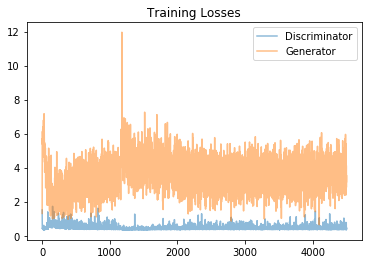

In [31]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [32]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [33]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

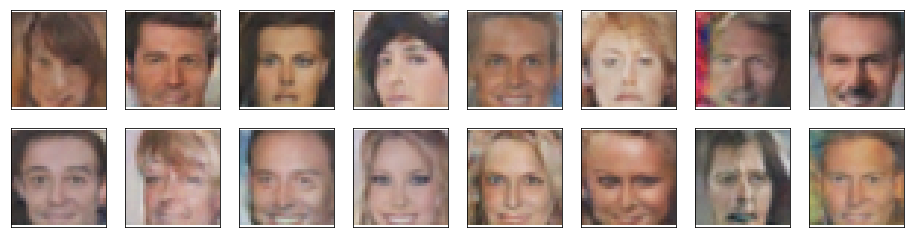

In [34]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
Looking closely, the left and right side of the generated samples are from different people.  I wonder if I cleaned up my sample/training data and only allowed evenly, front facing images if this phenomenon would go away.  Probably the most important thing I would do next is increase the layer count in both my Generator and my Discriminator.  That way I could pick up more features that would possibly bring a more realistic output from the Generator.  I also think that if I used a higher pixel count (instead of 64 x 64), the model would be able to identify finer features that would help the output from the Generator.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.